In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_csv("Product Demand.csv")

In [4]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,St john's,Category_006,1/8/2014,2.0
1,Product_1724,St john's,Category_003,5/31/2014,108.0
2,Product_1521,Surrey,Category_019,6/24/2014,85000.0
3,Product_1521,Surrey,Category_019,6/24/2014,7000.0
4,Product_1507,Oshawa,Category_019,9/2/2014,1250.0


In [5]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [6]:
df.shape

(1048575, 5)

### Data Definition
* `Product_Code`: Product identifier
* `Warehouse`: Identifier for the warehouse
* `Product_Category`: Category of the product
* `Date`: Date of the order
* `Order_Demand`: Demand for the product

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Product_Code      1048575 non-null  object 
 1   Warehouse         1048575 non-null  object 
 2   Product_Category  1048575 non-null  object 
 3   Date              1037336 non-null  object 
 4   Order_Demand      1048575 non-null  float64
dtypes: float64(1), object(4)
memory usage: 40.0+ MB


In [8]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

# Pre-processing

* The output indicates that there are 11,239 missing values in the `Date` column. To proceed with the analysis, we need to handle these missing values appropriately. We can either drop the rows with missing dates or try to impute them if there's a logical way to do so. Given that the `Date` column is crucial for time series analysis, dropping the rows with missing dates might be the best approach.

In [9]:
df=df.dropna()

In [10]:
df["Date"].isnull().sum()

0

* handle invalid dates such as "2015-02-29" and "2019-02-29" (both of which should be valid since 2016 and 2020 are leap years, but 2015 and 2019 are not), we adjust invalid dates to valid ones before converting the format.

In [11]:
df.loc[df['Date'] == '2015-02-29', 'Date'] = '2015/02/28'
df.loc[df['Date']=='2019-02-29', 'Date']='2019/02/28'

* This line converts the `Date` column in the DataFrame to datetime format, ensuring that all entries are recognized as dates. This allows for easier manipulation and analysis of date-related data.

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df['Date'].isnull().sum()

0

* converting the `Order_Demand` column in the DataFrame to numeric values, setting any non-convertible values to NaN.

In [14]:
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')

In [15]:
df['Order_Demand'].isnull().sum()

0

#### Handling Negative Demand Values

* This process involves checking the `Order_Demand` column for any negative values, which are assumed to be data collection errors. Upon identifying negative values, they are converted to their positive equivalents to ensure the data accurately reflects the demand without negative discrepancies.

In [16]:
negative_values = df[df['Order_Demand'] < 0]
negative_values.shape

(5997, 5)

* so, we are having `5997` negative entries for `Order_Demand`

In [17]:
negative_values.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
849249,Product_1394,Oshawa,Category_019,2019-01-04,-23.743563
849250,Product_1431,Oshawa,Category_019,2019-01-04,-50.954626
849251,Product_0439,Oshawa,Category_012,2019-01-04,-78.165689
849252,Product_1794,Oshawa,Category_024,2019-01-04,-105.376751
849253,Product_1356,Oshawa,Category_019,2019-01-04,-132.587814


* converting the negative values in to positive values.

In [18]:
df['Order_Demand'] = df['Order_Demand'].abs()
negative_values_after = df[df['Order_Demand'] < 0]
negative_values_after.shape

(0, 5)

#### Grouping and Summing Order Demand
* This step consolidates the order demand data to avoid duplicates and ensure accurate analysis by aggregating the total demand for each unique combination of date, product code, product category, and warehouse. This aggregated data is essential for understanding demand patterns, inventory needs, and is also beneficial for regression analysis as it provides a cleaner and more structured dataset for modeling and predictions.

In [19]:
# Group by Date and Product_Code and sum the Order_Demand
df_grouped = df.groupby(['Date', 'Product_Code', 'Product_Category', 'Warehouse'])['Order_Demand'].sum().reset_index()

# Visualizing & Analyzing the data

## 1. Top 10 Product Categories by Demand
This code calculates and displays a bar chart of the top 10 product categories based on total order demand. It provides a clear visualization of the demand levels across these categories, enhancing insights into their relative importance.

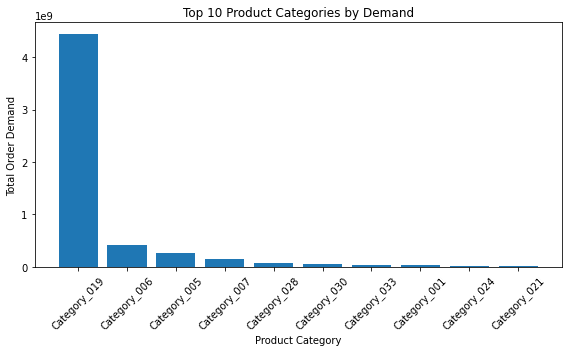

In [20]:
category_demand = df_grouped.groupby('Product_Category')['Order_Demand'].sum().reset_index()
top_categories = category_demand.sort_values(by='Order_Demand', ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.bar(top_categories['Product_Category'], top_categories['Order_Demand'])
plt.xlabel('Product Category')
plt.ylabel('Total Order Demand')
plt.title('Top 10 Product Categories by Demand')
plt.xticks(rotation=45)
plt.tight_layout() #all elements fit within the figure area without overlapping

plt.show()

## 2. Demand Trends Over the Years by Top 5 Product Categories
This code identifies the top 5 product categories based on total demand, calculates the yearly demand for these categories, and plots the demand trends over the years, showing how demand has changed annually for each of the top categories.

<ipython-input-21-b8755bfa2d8a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['Year'] = top_5_df['Date'].dt.year


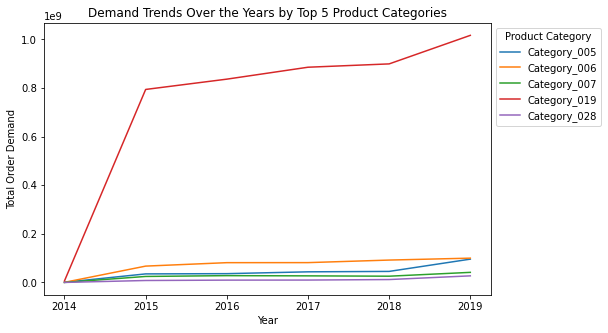

In [21]:
total_demand_by_category = df_grouped.groupby('Product_Category')['Order_Demand'].sum()
top_5_categories = total_demand_by_category.nlargest(5).index # top 10 category
top_5_df = df_grouped[df_grouped['Product_Category'].isin(top_5_categories)]  #filtering top 5 ctegories 
# selecting years for x axis
top_5_df['Year'] = top_5_df['Date'].dt.year 
#categories demand for each year for y axis 
category_year_demand_top_5 = top_5_df.groupby(['Product_Category', 'Year'])['Order_Demand'].sum().unstack() 

category_year_demand_top_5.T.plot(figsize=(8, 5))
plt.title('Demand Trends Over the Years by Top 5 Product Categories')
plt.xlabel('Year')
plt.ylabel('Total Order Demand')
plt.legend(title='Product Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## 3.  Observing and Tracking Top 5 Products in 2014
This process involves filtering the data for the year 2014, identifying the top 5 product codes based on demand, and visualizing their demand trends over subsequent years. The goal is to analyze how the demand for these top products has changed over time.

In [22]:
 df_2014 = df_grouped[df_grouped['Date'].dt.year == 2014]

#### Top 5 Products by Demand in 2014
* This analysis identifies the top 5 products based on total demand in 2014 and visualizes them with a bar chart. The chart displays product codes on the x-axis and their total demand on the y-axis, highlighting the highest-demand products of that year.

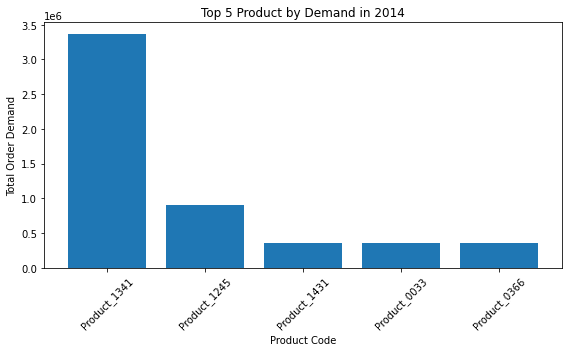

In [23]:
pro_demand_in_2014 =df_2014.groupby('Product_Code')['Order_Demand'].sum().reset_index()
top_pro = pro_demand_in_2014.sort_values(by='Order_Demand', ascending=False).head(5)

plt.figure(figsize=(8, 5))
plt.bar(top_pro['Product_Code'], top_pro['Order_Demand'])
plt.xlabel('Product Code')
plt.ylabel('Total Order Demand')
plt.title('Top 5 Product by Demand in 2014')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
#top 5 products based on total demand in 2014 will give top 5 product names
top_5_pro = df_2014.groupby('Product_Code')['Order_Demand'].sum().nlargest(5).index 
print(top_5_pro)
#filtering mian df with product names we got from above
top_5_pro_df = df_grouped[df_grouped['Product_Code'].isin(top_5_pro)].copy()
top_5_pro_df.head()

Index(['Product_1341', 'Product_1245', 'Product_1431', 'Product_0033',
       'Product_0366'],
      dtype='object', name='Product_Code')


,Date,Product_Code,Product_Category,Warehouse,Order_Demand
101,2014-12-13,Product_1431,Category_019,Surrey,1000.0
125,2014-12-15,Product_1431,Category_019,St john's,8000.0
126,2014-12-15,Product_1431,Category_019,Surrey,1000.0
129,2014-12-16,Product_0033,Category_005,Surrey,30000.0
173,2014-12-20,Product_0033,Category_005,Oshawa,2000.0


#### Demand Trends Over the Years for Top 5 Products in 2014
* This analysis plots the demand trends for the top 5 products identified in 2014, showing how each product's demand has evolved over the years. The plot displays total annual demand for each product, providing insights into long-term demand patterns and variations across these key products.

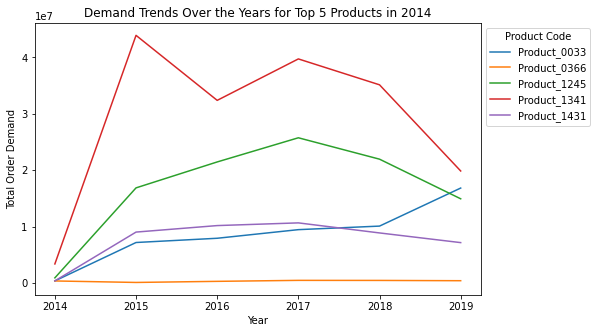

In [25]:
# Selecting years for x axis
top_5_pro_df['Year'] = top_5_pro_df['Date'].dt.year

# Calculate the products' demand for each year
product_year_demand_top_5 = top_5_pro_df.groupby(['Product_Code', 'Year'])['Order_Demand'].sum().unstack()

product_year_demand_top_5.T.plot(figsize=(8, 5))
plt.title('Demand Trends Over the Years for Top 5 Products in 2014')
plt.xlabel('Year')
plt.ylabel('Total Order Demand')
plt.legend(title='Product Code', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## 4.  Demand Forecast for Top Product in Highest Demand Category of 2019

* we first filtered the data for the year 2019 to identify the product category with the highest total demand. Next, we determined the product code with the highest demand within this top category. We then filtered the dataset to include only the data for this top product within the highest demand category, preparing it for further analysis and forecasting.

In [26]:
df_2019 = df_grouped[df_grouped['Date'].dt.year == 2019]

#product category with the highest demand
top_category_2019 = df_2019.groupby('Product_Category')['Order_Demand'].sum().idxmax()

# Filter data for the top category in 2019 from actual data
top_category = df_grouped[df_grouped['Product_Category'] == top_category_2019]

# product code having  highest-demand in this product category  category
top_product = top_category.groupby('Product_Code')['Order_Demand'].sum().idxmax()

# Filter data for the top product code from actual data
top_product_data = top_category[top_category['Product_Code'] == top_product]

#### Setting Date as Index
* This step sets the `Date` column as the index of `the top_product_data`. By doing so, it facilitates time-series operations such as resampling and plotting, allowing for easier analysis of demand trends over time.

In [27]:
top_product_data.set_index('Date', inplace=True)

#### Resampling Data to Monthly Frequency
This step resamples the demand data for the top product to a monthly frequency, summing the values within each month. This aggregation simplifies the data and makes it more suitable for time-series analysis and forecasting, providing a clearer view of monthly demand trends.

In [28]:
df_monthly = top_product_data.resample("M").sum()
df_monthly.head()

,Order_Demand
Date,
2015-01-31,8911000.0
2015-02-28,8131000.0
2015-03-31,7775000.0
2015-04-30,8960000.0
2015-05-31,8475000.0


#### Splitting Data into Training and Test Sets
* This step divides the monthly resampled demand data into training and test sets. The training set includes data up to the end of 2018, while the test set covers the year 2019. This separation allows for model training on historical data and evaluation on more recent data.

In [29]:
# Split data into training and test sets
train_data = df_monthly[:'2018']
test_data = df_monthly['2019':]
print("Training Data:",train_data.shape," ","Testing Data:" ,test_data.shape)

Training Data: (48, 1)   Testing Data: (12, 1)


#### Forecasting Demand using Exponential Smoothing 
* This analysis involves fitting an Exponential Smoothing model to the training data, which includes demand data up to the end of 2018. The model is then used to forecast demand for 2019 and 2020. The results are visualized with a plot showing the original training data, the test data for 2019 , and the forecasted values, allowing for a comparison of actual demand versus predicted trends.

In [30]:
# Fit the model on the training set
model = ExponentialSmoothing(train_data,trend='add',seasonal='add',seasonal_periods=12).fit()
# Forecast for the test period
pred = model.forecast(steps = 24) # predicting for 2019-2020 and 2020-2021

C:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


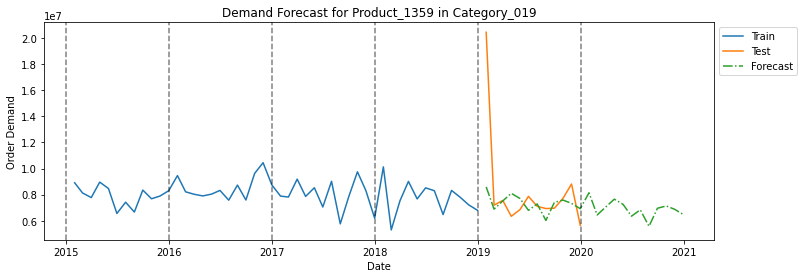

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test',)
plt.plot(pred, label='Forecast',linestyle="-.")
plt.title(f'Demand Forecast for {top_product} in {top_category_2019}')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
for year in range (2015, 2021):
    plt.axvline(datetime(year,1,1), color= 'k', linestyle='--', alpha=0.5)
plt.show()

## 5. Decomposition and Anomaly Detection in Demand Data
* This analysis involves decomposing the monthly demand data into its observed, trend, seasonal, and residual components using seasonal decomposition. The results are visualized through multiple plots to illustrate each component's contribution. Additionally, an anomaly detection process identifies unusual deviations from the expected pattern, with anomalies highlighted on a plot to visualize periods of significant deviation from the norm. This helps in understanding underlying patterns and detecting any irregularities in the demand data.

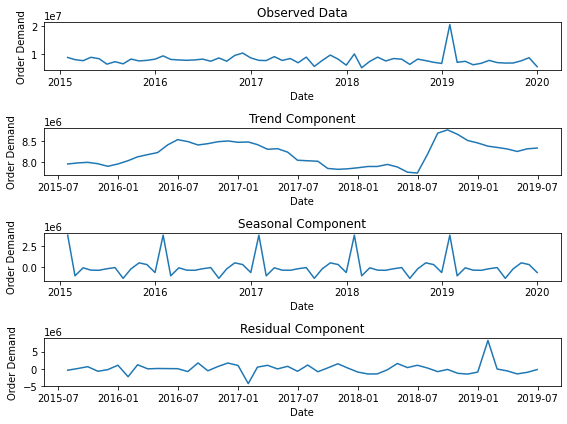

In [72]:
decomposition = seasonal_decompose(df_monthly, model='add')

# Plot the decomposition
plt.figure(figsize=(8, 6))

# Plot observed
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed Data')
plt.xlabel('Date')
plt.ylabel('Order Demand')

# Plot trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Order Demand')

# Plot seasonal
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Order Demand')

# Plot residual
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Order Demand')

plt.tight_layout()
plt.show()

#### Comparison of Original Data and Estimated Trend with Seasonal Component
* This plot compares the original monthly demand data with the estimated demand derived from the trend and seasonal components. It visually demonstrates how well the combined trend and seasonal components capture the original data patterns, providing insights into the accuracy of the trend and seasonal adjustments.

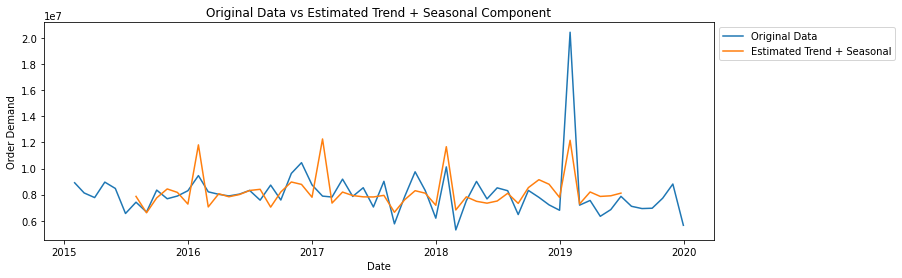

In [73]:
plt.figure(figsize=(12,4))
plt.plot(df_monthly, label='Original Data')
estimated = decomposition.trend + decomposition.seasonal
plt.plot(estimated, label='Estimated Trend + Seasonal')

# Add titles and labels
plt.title('Original Data vs Estimated Trend + Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.show()

# Anomaly Detection

#### Calculating Anomaly Detection Bounds
* This code computes the mean and standard deviation of the residuals to establish upper and lower bounds for anomaly detection, marking the range within which residuals are considered normal.

In [74]:
resid_mu = decomposition.resid.mean()
resid_dev =decomposition.resid.std()
lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

* This plot visualizes the residuals from the decomposition process, highlighting anomalies by shading the region between the calculated upper and lower bounds. The shaded area represents the range of normal residual values, making deviations from this range stand out as potential anomalies.

Text(0, 0.5, 'Order Demand')

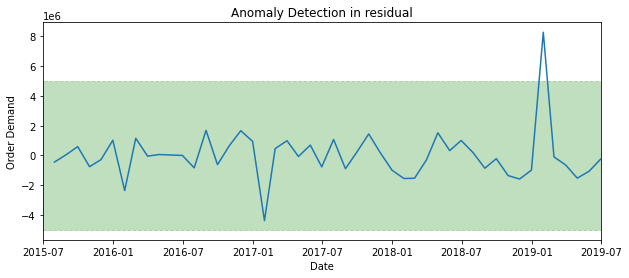

In [75]:
resid =decomposition.resid
plt.figure(figsize=(10,4))
plt.plot(resid)
plt.fill_between([datetime(2015,7,1),datetime(2019,7,1)], lower, upper, color='g', alpha=0.25, linestyle="--")
plt.xlim(datetime(2015,7,1),datetime(2019,7,1))
plt.title("Anomaly Detection in residual")
plt.xlabel('Date')
plt.ylabel('Order Demand')

In [76]:
anomalies = df_monthly[(resid<lower)|(resid>upper)]
anomalies

,Order_Demand
Date,
2019-01-31,2.044359e+07


* This plot displays monthly demand data with yearly markers and highlights anomalies. One anomaly is identified on January 31, 2019, providing a clear view of unusual demand patterns in the context of annual trends.

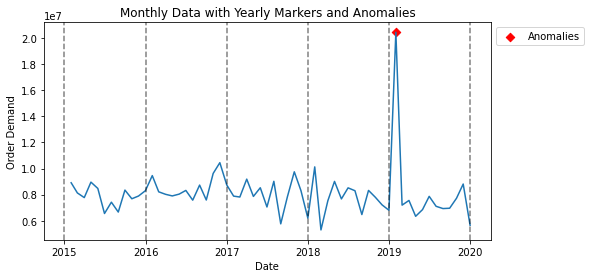

In [77]:
plt.figure(figsize=(8,4))
plt.plot(df_monthly)
for year in range (2015, 2021):
    plt.axvline(datetime(year,1,1), color= 'k', linestyle='--', alpha=0.5)
plt.scatter(anomalies.index, anomalies, color='r',marker='D',label='Anomalies')
plt.title('Monthly Data with Yearly Markers and Anomalies')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')

plt.show()